# Introduction

How much does what is included in the annotation set matter?

In [1]:
import seaborn
import scipy
import anndata
import pandas
import scanpy
import numpy
from pathlib import Path
from matplotlib import pyplot, cm
import sys
import pysam
from collections import Counter
from IPython import display

import upsetplot

In [2]:
MEX = str(Path("~/proj/mex_gene_archive").expanduser())
if MEX not in sys.path:
    sys.path.append(MEX)
from mex_gene_archive.filter import write_filtered_mtx
from mex_gene_archive.reader import read_mex_archive_as_anndata

In [3]:
pandas.options.display.max_rows = 300

In [4]:
pwd

'/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/SRP199641/SRX5908538_HCC1395_LLU_10x'

In [5]:
project_root = Path("../..").absolute()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from common import compute_spearman_anndata

In [6]:
def scanpy_load_solo278a_mtx(analysis_dir, quantification="Gene", mode="filtered", multiread="Unique"):
    assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"
    assert quantification in ["Gene", "GeneFull", "GeneFull_Ex50pAS", "SJ"]
    MULTIREAD_MATRIX = {
    "Unique": "matrix.mtx",
    "Rescue": "UniqueAndMult-Rescue.mtx",
    "EM": "UniqueAndMult-EM.mtx",
    }
    assert multiread in MULTIREAD_MATRIX

    analysis_dir = Path(analysis_dir)
    
    solo_dir = analysis_dir / "Solo.out" / quantification 
    solo = scanpy.read_mtx(solo_dir / "raw" / MULTIREAD_MATRIX[multiread]).T
    solo_vars = pandas.read_csv(
        solo_dir / "raw" / "features.tsv", header=None, sep="\t"
    ).values.T
    solo_obs = pandas.read_csv(
        solo_dir / "raw" / "barcodes.tsv", header=None, sep="\t"
    ).values.T
    solo.obs_names = solo_obs[0]
    solo.var_names = solo_vars[0]
    
    if mode == "filtered":
        solo_obs = pandas.read_csv(
            solo_dir / mode / "barcodes.tsv", header=None, sep="\t"
        ).values.T[0]
        solo = solo[solo_obs,:]
        

    solo.obs["counts"] = solo.X.sum(axis=1)
    solo.obs["ngenes"] = numpy.array((solo.X > 0).sum(axis=1))

    return solo



# Load Datasets

In [7]:
algorithm_roots = {
    'star-2021-09-10': Path("fullsolo_multi_dev_EoI_2.7.9a_2021-09-10/GeneFull_Ex50pAS_EM.tar.gz"),
    'star-2021-12-22': Path("fullsolo_eoi_pipeline/GeneFull_Ex50pAS_EM_raw.tar.gz"),
}

In [8]:
algorithm_raw = {}
for algorithm in algorithm_roots:
    print("loading {}".format(algorithm))
    algorithm_raw[algorithm] = read_mex_archive_as_anndata(algorithm_roots[algorithm])


loading star-2021-09-10
loading star-2021-12-22


# Cell barcodes in common

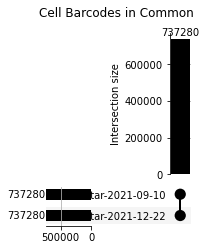

In [11]:
algorithm_cell_barcodes = {}
for algorithm in algorithm_raw:
    algorithm_cell_barcodes[algorithm] = algorithm_raw[algorithm].obs_names

common_cell_barcode_set = upsetplot.from_contents(algorithm_cell_barcodes)
f = pyplot.figure()
f.suptitle("Cell Barcodes in Common")
_ = upsetplot.plot(common_cell_barcode_set, fig=f, show_counts=True)


In [15]:
common_cell_barcode_set = None
for algorithm in algorithm_raw:
    if common_cell_barcode_set is None:
        common_cell_barcode_set = set(algorithm_raw[algorithm].obs_names)
    else:
        common_cell_barcode_set = common_cell_barcode_set.intersection(algorithm_raw[algorithm].obs_names)

print('common_cell_barcode_set', len(common_cell_barcode_set))
first = next(iter(algorithm_raw))
common_cell_barcodes = [x for x in algorithm_raw[first].obs_names if x in common_cell_barcode_set]
print('common_cell_barcodes', len(common_cell_barcodes))


common_cell_barcode_set 737280
common_cell_barcodes 737280


# Gene IDs in common

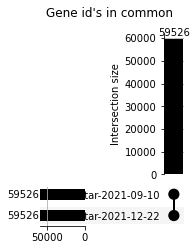

In [16]:
algorithm_gene_base_ids = {}
for algorithm in algorithm_raw:
    algorithm_gene_base_ids[algorithm] = set(algorithm_raw[algorithm].var_names)

common_gene_base_contents = upsetplot.from_contents(algorithm_gene_base_ids)

# tenx is using gencode.v32.primary_assembly.annotation.gtf.filtered
f = pyplot.figure()
f.suptitle("Gene id's in common")
_ = upsetplot.plot(common_gene_base_contents, fig=f, show_counts=True)

In [17]:
for algorithm in algorithm_raw:
    matrix = algorithm_raw[algorithm]
    print(algorithm, matrix.X.sum())
    

star-2021-09-10 77055230.0
star-2021-12-22 77055230.0


In [18]:
numpy.all(algorithm_raw["star-2021-09-10"].X.sum(axis=0) == algorithm_raw["star-2021-12-22"].X.sum(axis=0))

True

In [19]:
numpy.all(algorithm_raw["star-2021-09-10"].X.sum(axis=1) == algorithm_raw["star-2021-12-22"].X.sum(axis=1))

False

In [20]:
different_cells = (algorithm_raw["star-2021-09-10"].X.sum(axis=1) != algorithm_raw["star-2021-12-22"].X.sum(axis=1))

In [25]:
algorithm_raw["star-2021-09-10"][different_cells].X.sum()

53.999996

In [26]:
algorithm_raw["star-2021-12-22"][different_cells].X.sum()

54.000008

In [31]:
algorithm_raw["star-2021-09-10"][different_cells].X.tonumpy() == algorithm_raw["star-2021-12-22"][different_cells].X.to_numpy()

AttributeError: tonumpy not found

In [ ]:
assert 0

# Compute correlations of cells in common between all methods

In [ ]:
def compute_spearman_anndata(left, right):
    assert left.shape == right.shape, "Shapes must be the same"
    if isinstance(left, anndata._core.anndata.AnnData):
        left = left.to_df().T
    if isinstance(right, anndata._core.anndata.AnnData):
        right = right.to_df().T

    #print(left.shape[0])
    #print(left[0].shape)
    #print(right[0].shape)
    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.spearmanr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    #[~numpy.isnan(cors)]
    return cors


def compute_correlations(table):
    programs = list(table.keys())
    correlations = {}
    dense = {}
    for name_x in programs:
        dense[name_x] = table[name_x].to_df().T

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            print("Processing {} {}".format(name_x, name_y))
            cs_cors = compute_spearman_anndata(dense[name_x], dense[name_y])
            correlations.setdefault(name_x, {})[name_y] = cs_cors
    return correlations

algorithm_correlations = compute_correlations(algorithm_raw)

In [ ]:
def plot_cell_correlation_histogram(table, title=None, bins=50, programs=None):
    if programs is None:
        programs = list(table.keys())
    cell_hists = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)
    if title is not None:
        f.suptitle(title.format(metric=metric))

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            spearman = numpy.array(table[name_x][name_y])
            spearman = spearman[~numpy.isnan(spearman)]
            count = len(spearman)
            median = numpy.median(spearman)
            mean = numpy.mean(spearman)
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(spearman, bins=bins, density=True)
            ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCount {count}', xy=(0.1, 0.6), xycoords='axes fraction')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    #f.tight_layout()
    

In [ ]:
plot_cell_correlation_histogram(algorithm_correlations)

# Scatter plot of method genes in common over all cells

In [ ]:
def plot_algorithm_sums(table, title=None, programs=None):
    if programs is None:
        programs = list(table.keys())
    scatter = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)    
    if title is not None:
        f.suptitle(title.format(metric=metric))

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            scatter.setdefault(name_x, {})[name_y] = ax.scatter(
                numpy.asarray(table[name_x].X.sum(axis=1).T)[0], 
                numpy.asarray(table[name_y].X.sum(axis=1).T)[0],
                s=0.5
            )
            ax.set_xscale('log')
            ax.set_yscale('log')
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("per algorithm sum of genes over all cells")
    #f.tight_layout()
    

In [ ]:
plot_algorithm_sums(algorithm_common)

# Calculate scatter plots of gene expression for worst, median, and best correlated cells

In [ ]:
algorithm_dense = {}
for algorithm in algorithm_common:
    algorithm_dense[algorithm] = algorithm_common[algorithm].to_df().T


In [ ]:
def sc_scatter(table, correlations, name_x, name_y, cell_id, ax=None):
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)
    
    set1 = cm.get_cmap('Set1').colors
    colors = [{True: set1[0], False: set1[1]}[is_spike(x)] for x in table[name_x].index]

    ax.plot([-5,10], [-5,10], c=set1[2])
    ax.scatter(numpy.log2(table[name_x][cell_id]+0.01), numpy.log2(table[name_y][cell_id]+0.01), color=colors, s=2)
    spearman = correlations[name_x][name_y][cell_id]
    expressed_in_x = table[name_x][cell_id] > 0
    expressed_in_y = table[name_y][cell_id] > 0
    count = table[name_x][expressed_in_x & expressed_in_y].shape[0]
    ax.set_title(f'id {cell_id}\nSpearman {spearman:0.4}\nCount: {count}')
    ax.set_xlabel(name_x)
    ax.set_ylabel(name_y)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)

def show_scatter_extremes(dense_mat, correlations, name_x, name_y):
    scores = correlations[name_x][name_y]
    best_cell = scores.idxmax()
    worst_cell = scores.idxmin()
    # find smallest absolute difference from median and use that as median cell
    median = numpy.abs(scores - scores.median())
    median_cell = median.idxmin()
    
    f = pyplot.figure(figsize=(12,4))
    #f.suptitle(f'{metric} worst, median and best cells')
    axes = f.subplots(1,3, sharex=True, sharey=True)
    sc_scatter(dense_mat, correlations, name_x, name_y, worst_cell, ax=axes[0])
    sc_scatter(dense_mat, correlations, name_x, name_y, median_cell, ax=axes[1])
    sc_scatter(dense_mat, correlations, name_x, name_y, best_cell, ax=axes[2])
    return f

# Scatter plots of gene expression for worst, median, and best correlated cells

In [ ]:
def plot_all_scatter_extremes(table, correlations):
    programs = list(table.keys())


    for name_x in programs:
        for name_y in programs[programs.index(name_x)+1:]:
            #print("Comparing {} {}".format(name_x, name_y))
            f = show_scatter_extremes(table, correlations, name_x, name_y)
            
            
plot_all_scatter_extremes(algorithm_dense, algorithm_correlations)

# Calculate scatter plot of cells with the highest expression sum

In [ ]:
def plot_algorithm_most_expressed(table, correlations, title=None, programs=None):
    if programs is None:
        programs = list(table.keys())
    scatter = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)
    if title is not None:
        f.suptitle(title.format(metric=metric))


    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if x == 0:
                ax.set_ylabel(name_y)

            max_cell = algorithm_dense[name_x].sum(axis=0).idxmax()
            scatter.setdefault(name_x, {})[name_y] = sc_scatter(table, correlations, name_x, name_y, max_cell, ax=ax)
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("Compare algorithms with cell with highest expression sum")
    #f.tight_layout()
    

# Scatter plot of cells with the highest expression sum

In [ ]:
plot_algorithm_most_expressed(algorithm_dense, algorithm_correlations)

# Lets try the scanpy tutorial

In [ ]:
for algorithm in algorithm_filtered:
    print("{algorithm} first phase QC".format(algorithm=algorithm))    
    if algorithm.startswith("tenx"):
        algorithm_filtered[algorithm].var['gene_name'] = [v32m_gene_id_to_name.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        algorithm_filtered[algorithm].var['gene_type'] = [v32m_gene_id_to_type.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
    else:
        algorithm_filtered[algorithm].var['gene_name'] = [v29_gene_id_to_name.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        algorithm_filtered[algorithm].var['gene_type'] = [v29_gene_id_to_type.get(x, x) for x in  algorithm_filtered[algorithm].var_names]
        
    scanpy.pl.highest_expr_genes(algorithm_filtered[algorithm], n_top=20, gene_symbols='gene_name')
    scanpy.pp.filter_cells(algorithm_filtered[algorithm], min_genes=200)
    scanpy.pp.filter_genes(algorithm_filtered[algorithm], min_cells=3)
    algorithm_filtered[algorithm].var['mt'] = algorithm_filtered[algorithm].var['gene_name'].str.startswith("MT-")
    scanpy.pp.calculate_qc_metrics(algorithm_filtered[algorithm], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    scanpy.pl.violin(
        algorithm_filtered[algorithm],
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
        jitter=0.4, multi_panel=True)
    scanpy.pl.scatter(algorithm_filtered[algorithm], x='total_counts', y='pct_counts_mt')
    scanpy.pl.scatter(algorithm_filtered[algorithm], x='total_counts', y='n_genes_by_counts')        

In [ ]:
count_filter = 8000
mt_filter = 10

In [ ]:
algorithm_scanpy_filtered = {}
algorithm_top_gene_ids = {}
algorithm_top_gene_names = {}
for algorithm in algorithm_filtered:
    #print(display.HTML('<h1>{algorithm} first phase QC</h1><a class="anchor-link" href="#{algorithm}-first-phase-QC">¶</a>'.format(algorithm=algorithm)))
    print("{algorithm} clustering".format(algorithm=algorithm))
    algorithm_scanpy_filtered[algorithm] = algorithm_filtered[algorithm][algorithm_filtered[algorithm].obs.n_genes_by_counts < count_filter, :]
    algorithm_scanpy_filtered[algorithm] = algorithm_scanpy_filtered[algorithm][algorithm_scanpy_filtered[algorithm].obs.pct_counts_mt < mt_filter, :]
    
    scanpy.pp.normalize_total(algorithm_scanpy_filtered[algorithm], target_sum=30000)
    scanpy.pp.log1p(algorithm_scanpy_filtered[algorithm])
    scanpy.pp.highly_variable_genes(algorithm_scanpy_filtered[algorithm], min_mean=0.0125, max_mean=3, min_disp=0.5)
    scanpy.pl.highly_variable_genes(algorithm_scanpy_filtered[algorithm])
    algorithm_scanpy_filtered[algorithm].raw = algorithm_scanpy_filtered[algorithm]
    algorithm_scanpy_filtered[algorithm] = algorithm_scanpy_filtered[algorithm][:, algorithm_scanpy_filtered[algorithm].var.highly_variable]
   
    scanpy.pp.regress_out( algorithm_scanpy_filtered[algorithm], ['total_counts', 'pct_counts_mt'])
    scanpy.pp.scale( algorithm_scanpy_filtered[algorithm], max_value=10)
    scanpy.tl.pca(algorithm_scanpy_filtered[algorithm], svd_solver='arpack')
    scanpy.pl.pca(algorithm_scanpy_filtered[algorithm])

    scanpy.pl.pca_variance_ratio(algorithm_scanpy_filtered[algorithm], log=True)
    
    scanpy.pp.neighbors(algorithm_scanpy_filtered[algorithm], n_neighbors=10, n_pcs=40)
    scanpy.tl.umap(algorithm_scanpy_filtered[algorithm])
    scanpy.pl.umap(algorithm_scanpy_filtered[algorithm])
    
    scanpy.tl.louvain(algorithm_scanpy_filtered[algorithm])
    scanpy.pl.umap(algorithm_scanpy_filtered[algorithm], color=['louvain'])
    
    scanpy.tl.rank_genes_groups(algorithm_scanpy_filtered[algorithm], 'louvain', method='t-test')
    scanpy.pl.rank_genes_groups(algorithm_scanpy_filtered[algorithm], n_genes=25, sharey=False, gene_symbols='gene_name')
    
    algorithm_top_gene_ids[algorithm] = pandas.DataFrame(algorithm_scanpy_filtered[algorithm].uns['rank_genes_groups']['names'])    
    if algorithm == "tenx solo uniq":
        algorithm_top_gene_names[algorithm] = algorithm_top_gene_ids[algorithm].applymap(lambda x: v32m_gene_id_to_name.get(x, x))
    else:
        algorithm_top_gene_names[algorithm] = algorithm_top_gene_ids[algorithm].applymap(lambda x: v29_gene_id_to_name.get(x, x))
    print('top gene names')
    print(algorithm_top_gene_names[algorithm].head(5))

# Cell barcodes left in common after scanpy filtering

In [ ]:
tutoral_barcode_set = upsetplot.from_contents({
    k: algorithm_scanpy_filtered[k].obs_names for k in algorithm_scanpy_filtered
})
f = pyplot.figure()
f.suptitle("Cell barcodes in common after scanpy")
_ = upsetplot.plot(tutoral_barcode_set, show_counts=True, fig=f)


# Gene IDs in common after scanpy filtering

In [ ]:
common_filtered_gene_base_contents = {}
for algorithm in algorithm_scanpy_filtered:
    #if algorithm == 'tenx solo uniq':
    #    common_filtered_gene_base_contents[algorithm] = {gene_id for gene_id in algorithm_scanpy_filtered[algorithm].var_names}
    #else:
    #common_filtered_gene_base_contents[algorithm] = {gene_id.split('.')[0] for gene_id in algorithm_scanpy_filtered[algorithm].var_names}
    common_filtered_gene_base_contents[algorithm] = set(algorithm_scanpy_filtered[algorithm].var_names)

# tenx is using gencode.v32.primary_assembly.annotation.gtf.filtered
common_filtered_gene_base_set = upsetplot.from_contents(common_filtered_gene_base_contents)

f = pyplot.figure()
f.suptitle("Gene ids in common after scanpy")
_ = upsetplot.plot(common_filtered_gene_base_set, show_counts=True, fig=f)

In [ ]:
common_filtered_gene_base_set

In [ ]:
#common_filtered_gene_base_set.loc[True, False, True]['id']

In [ ]:
#v29_gtf.set_index('gene_id').reindex(common_filtered_gene_base_set.loc[True, False, True]['id'])

In [ ]:
def build_confusion_matrix(left, right, N=20):
    confusion = {}
    for cluster in left:
        for gene in left[cluster].head(N):
            confusion.setdefault(gene, {})['left'] = int(cluster)

    for cluster in right:
        for gene in right[cluster].head(N):
            confusion.setdefault(gene, {})['right'] = int(cluster)

    last_left = int(left.columns[-1]) + 1
    last_right = int(right.columns[-1]) + 1

    confusion_matrix = numpy.zeros((last_left+1, last_right+1))

    for gene in confusion:
        x = confusion[gene].get('left', last_left)
        y = confusion[gene].get('right', last_right)
        confusion_matrix[x,y] += 1
    return confusion_matrix

# Confusion matrices between top N genes in each cluster

In [ ]:
def plot_algorithm_confusion(table, programs=None, N=20):
    if programs is None:
        programs = list(table.keys())
    confusion = {}
    plot_size = len(programs)-1
    figsize = (3 * plot_size, 3 * plot_size)
    f = pyplot.figure(figsize=figsize)

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    if plot_size == 1:
        axes = numpy.array([[axes]])
    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            cm = build_confusion_matrix(table[name_x], table[name_y], N)
            seaborn.heatmap(cm, annot=False, ax=ax)
            
            if x == 0:
                ax.set_ylabel(name_y)
    for y in range(plot_size):
        axes[0, y].set_title(programs[y])
        axes[plot_size-1, y].set_xlabel(programs[y])
    f.suptitle("Gene name confusion matrix of top {} genes".format(N))
    #f.tight_layout()


In [ ]:
plot_algorithm_confusion(algorithm_top_gene_names, N=20)

In [ ]:
plot_algorithm_confusion(algorithm_top_gene_names, N=200)

In [ ]:
plot_algorithm_confusion(algorithm_top_gene_names, N=2000)

# Smoosh datasets

In [ ]:
combined = anndata.concat(
    [algorithm_filtered[x] for x in algorithm_filtered],
    merge='same',
)
combined

In [ ]:
combined.var['gene_name'] = [v29_gene_id_to_name.get(x, x) for x in combined.var_names]
combined.var['gene_type'] = [v29_gene_id_to_type.get(x, x) for x in combined.var_names]
combined

In [ ]:
method = []
for algorithm in algorithm_filtered:
    method.extend([algorithm] * len(algorithm_filtered[algorithm].obs_names))
print(len(method), len(algorithm_filtered[algorithm].obs_names))
print(combined.shape)
combined.obs['method'] = method
combined

In [ ]:
scanpy.pl.highest_expr_genes(combined, n_top=20, gene_symbols='gene_name')
scanpy.pp.filter_cells(combined, min_genes=200)
scanpy.pp.filter_genes(combined, min_cells=3)
algorithm_filtered[algorithm].var['mt'] = combined.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(combined, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
scanpy.pl.violin(
    combined,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True)
scanpy.pl.scatter(combined, x='total_counts', y='pct_counts_mt')
scanpy.pl.scatter(combined, x='total_counts', y='n_genes_by_counts')        

In [ ]:
#print(display.HTML('<h1>{algorithm} first phase QC</h1><a class="anchor-link" href="#{algorithm}-first-phase-QC">¶</a>'.format(algorithm=algorithm)))
combined_scanpy = combined[combined.obs.n_genes_by_counts < count_filter, :]
combined_scanpy = combined_scanpy[combined_scanpy.obs.pct_counts_mt < mt_filter, :]

scanpy.pp.normalize_total(combined_scanpy, target_sum=30000)
scanpy.pp.log1p(combined_scanpy)
scanpy.pp.highly_variable_genes(combined_scanpy, min_mean=0.0125, max_mean=3, min_disp=0.5)
scanpy.pl.highly_variable_genes(combined_scanpy)
combined_scanpy.raw = combined_scanpy
combined_scanpy = combined_scanpy[:, combined_scanpy.var.highly_variable]

scanpy.pp.regress_out(combined_scanpy, ['total_counts', 'pct_counts_mt'])
scanpy.pp.scale(combined_scanpy, max_value=10)
scanpy.tl.pca(combined_scanpy, svd_solver='arpack')
scanpy.pl.pca(combined_scanpy)

scanpy.pl.pca_variance_ratio(combined_scanpy, log=True)

scanpy.pp.neighbors(combined_scanpy, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(combined_scanpy)
scanpy.pl.umap(combined_scanpy)

scanpy.tl.louvain(combined_scanpy)
scanpy.pl.umap(combined_scanpy, color=['louvain'])

scanpy.tl.leiden(combined_scanpy)
scanpy.pl.umap(combined_scanpy, color=['leiden'])

scanpy.tl.rank_genes_groups(combined_scanpy, 'leiden', method='t-test')
scanpy.pl.rank_genes_groups(combined_scanpy, n_genes=25, sharey=False, gene_symbols='gene_name')

combined_top_gene_ids = pandas.DataFrame(combined_scanpy.uns['rank_genes_groups']['names'])    
print('top gene names')
combined_top_gene_names = combined_top_gene_ids.applymap(lambda x: v29_gene_id_to_name.get(x, x))
print('top gene names')
combined_top_gene_names

# UMAP EM reads

In [ ]:
scanpy.pl.umap(combined_scanpy, color=['method'])

In [ ]:
scanpy.pl.umap(combined_scanpy, color=['leiden'])